In [1]:
"""
PyTorch script for model training (MobileNetV2).
Copyright (C) 2021 by Akira TAMAMORI
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files (the
"Software"), to deal in the Software without restriction, including
without limitation the rights to use, copy, modify, merge, publish,
distribute, sublicense, and/or sell copies of the Software, and to
permit persons to whom the Software is furnished to do so, subject to
the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

# Standard library imports.
import datetime
import os
import sys
from itertools import chain
import random
# Related third party imports.
import joblib
import numpy
import scipy.stats
import torch
import torch.utils.data
from scipy.special import softmax
from torch import optim
from torchinfo import summary
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

# Local application/library specific imports.
import util
from pytorch_model import Transformer_Decoder as Model

# Load configuration from YAML file.
CONFIG = util.load_yaml("./config.yaml")

# String constant: "cuda:0" or "cpu"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    numpy.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

In [3]:
def flatten(nested_list):
    """
    Flatten list.
    """
    return list(chain.from_iterable(nested_list))


def concat_features(file_list):
    """
    Extract features from audio files and then concate them into an array.
    """
    # calculate the number of dimensions
    n_features = []
    for file_id, file_name in enumerate(file_list):

        # extract feature from audio file.
        feature = util.extract_feature(file_name, CONFIG["feature"])
        feature = feature[:: CONFIG["feature"]["n_hop_frames"], :]

        if file_id == 0:
            features = numpy.zeros(
                (
                    len(file_list) * feature.shape[0],
                    CONFIG["feature"]["n_mels"] * CONFIG["feature"]["n_frames"],
                ),
                dtype=float,
            )

        features[
            feature.shape[0] * file_id : feature.shape[0] * (file_id + 1), :
        ] = feature

        n_features.append(feature.shape[0])

    return features, n_features


class DcaseDataset(torch.utils.data.Dataset):
    """
    Prepare dataset.
    """

    def __init__(self, unique_section_names, target_dir, mode):
        super().__init__()

        n_files_ea_section = []  # number of files for each section
        n_vectors_ea_file = []  # number of vectors for each file
        data = numpy.empty(
            (0, CONFIG["feature"]["n_frames"] * CONFIG["feature"]["n_mels"]),
            dtype=float,
        )
        
        for section_name in unique_section_names:
            # get file list for each section
            # all values of y_true are zero in training
            print("target_dir : %s" % (target_dir + "_" + section_name))
            files, _ = util.file_list_generator(
                target_dir=target_dir,
                section_name=section_name,
                dir_name="train",
                mode=mode,
            )
            print("number of files : %s" % (str(len(files))))

            n_files_ea_section.append(len(files))

            # extract features from audio files and
            # concatenate them into Numpy array.
            features, n_features = concat_features(files)

            data = numpy.append(data, features, axis=0)
            n_vectors_ea_file.append(n_features)

        n_vectors_ea_file = flatten(n_vectors_ea_file)

        # make target labels for conditioning
        # they are not one-hot vector!
        labels = numpy.zeros((data.shape[0]), dtype=int)
        start_index = 0
        for section_index in range(unique_section_names.shape[0]):
            for file_id in range(n_files_ea_section[section_index]):
                labels[
                    start_index : start_index + n_vectors_ea_file[file_id]
                ] = section_index
                start_index += n_vectors_ea_file[file_id]

        # 1D vector to 2D image (1ch)
        self.data = data.reshape(
            (
                data.shape[0],
                #1,  # number of channels
                CONFIG["feature"]["n_frames"],
                CONFIG["feature"]["n_mels"],
            )
        )

        self.labels = labels

    def __len__(self):
        return self.data.shape[0]  # return num of samples

    def __getitem__(self, index):
        sample = self.data[index, :]
        label = self.labels[index]

        return sample, label


In [4]:
def get_dataloader(dataset):
    """
    Make dataloader from dataset for training.
    """
    train_size = int(len(dataset) * (1.0 - CONFIG["training"]["validation_split"]))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size])

    data_loader_train = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=CONFIG["training"]["batch_size"],
        shuffle=CONFIG["training"]["shuffle"],
        drop_last=True,
    )
    data_loader_val = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=CONFIG["training"]["batch_size"],
        shuffle=False,
        drop_last=False,
    )

    # dataloader of training data for evaluation only
    data_loader_eval_train = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=CONFIG["training"]["batch_size"],
        shuffle=False,
        drop_last=False,
    )

    return data_loader_train, data_loader_val, data_loader_eval_train


def get_model(embed_dim, seq_len):
    """
    Instantiate AutoEncoder.
    """
    model = Model(embed_dim, seq_len).to(DEVICE)
    return model


def get_optimizer(model):
    """
    Instantiate optimizer.
    """

    optimizer = optim.Adam(
        params=model.parameters(),
        weight_decay=CONFIG["training"]["weight_decay"],
        lr=CONFIG["training"]["learning_rate"],
    )

    # optional
    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=CONFIG["training"]["lr_step_size"],
        gamma=CONFIG["training"]["lr_gamma"],
    )

    return optimizer, scheduler

In [5]:
def calc_anomaly_score(model, file_path, section_index):
    """
    Calculate anomaly score.
    """
    try:
        # extract features (log-mel spectrogram)
        data = util.extract_feature(file_name=file_path, config=CONFIG["feature"])
        data = data.reshape(
            (  # must be a tuple of ints
                data.shape[0],
                1,
                CONFIG["feature"]["n_frames"],
                CONFIG["feature"]["n_mels"],
            )
        )
    except FileNotFoundError:
        print("File broken!!: {}".format(file_path))

    condition = numpy.zeros((data.shape[0]), dtype=int)
    if section_index != -1:
        condition[:] = section_index

    feed_data = torch.from_numpy(data).clone()
    feed_data = feed_data.to(DEVICE).float()
    with torch.no_grad():
        output = model(feed_data)  # notice: unnormalized output
        output = output.to("cpu").detach().numpy().copy()  # tensor to numpy array.

    output = softmax(output, axis=1)
    prob = output[:, section_index]

    y_pred = numpy.mean(
        numpy.log(
            numpy.maximum(1.0 - prob, sys.float_info.epsilon)
            - numpy.log(numpy.maximum(prob, sys.float_info.epsilon))
        )
    )

    return y_pred


def fit_gamma_dist(model, target_dir, mode):
    """
    - Calculate anomaly scores over sections.
    - Fit gamma distribution for anomaly scores.
    - Save the parameters of the distribution.
    """

    section_names = util.get_section_names(target_dir, dir_name="train")
    dataset_scores = numpy.array([], dtype=numpy.float64)

    # calculate anomaly scores over sections
    for section_index, section_name in enumerate(section_names):
        section_files, _ = util.file_list_generator(
            target_dir=target_dir,
            section_name=section_name,
            dir_name="train",
            mode=mode,
        )
        section_scores = [0.0 for k in section_files]
        for file_idx, file_path in enumerate(section_files):
            section_scores[file_idx] = calc_anomaly_score(
                model, file_path=file_path, section_index=section_index
            )

        section_scores = numpy.array(section_scores)
        dataset_scores = numpy.append(dataset_scores, section_scores)

    dataset_scores = numpy.array(dataset_scores)

    # fit gamma distribution for anomaly scores
    gamma_params = scipy.stats.gamma.fit(dataset_scores)
    gamma_params = list(gamma_params)

    # save the parameters of the distribution
    score_file_path = "{model}/score_distr_{machine_type}.pkl".format(
        model=CONFIG["model_directory"], machine_type=os.path.split(target_dir)[1]
    )
    joblib.dump(gamma_params, score_file_path)


def save_model(model, model_dir, machine_type):
    """
    Save PyTorch model.
    """

    model_file_path = "{model}/model_{machine_type}.hdf5".format(
        model=model_dir, machine_type=machine_type
    )
    # if os.path.exists(model_file_path):
    #     print("Model already exists!")
    #     continue
    torch.save(model.state_dict(), model_file_path)
    print("save_model -> %s" % (model_file_path))

In [6]:
def training(model, data_loader, optimizer, scheduler=None):
    """
    Perform training
    """
    model.train()  # training mode
    train_loss = 0.0
    for data, label in data_loader:
        data = data.to(DEVICE).float()
        label = label.to(DEVICE).long()
        optimizer.zero_grad()  # reset gradient
        loss = model.get_loss(data, label)
        loss.backward()  # backpropagation
        train_loss += loss.item()
        optimizer.step()  # update paramerters

    if scheduler is not None:
        scheduler.step()  # update learning rate
    #_ = model.get_loss(data, label, imshow=True)
    # model.eval()
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for data, label in data_loader:
    #         data = data.to(DEVICE).float()
    #         label = label.to(DEVICE).long()
    #         outputs = model.get_loss(data)
    #         _, predicted = torch.max(outputs, 1)
    #         correct += (predicted == label).sum().item()
    #         total += label.size(0)

    print("loss: {:.6f} - ".format(train_loss / len(data_loader)))
    # print(
    #     "accuracy: {:.6f}% ({}/{})".format(
    #         100 * float(correct / total), correct, total
    #     ),
    # )


def validation(model, data_loader):
    """
    Perform validation
    """
    model.eval()  # validation mode
    val_loss = 0.0
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(DEVICE).float()
            label = label.to(DEVICE).long()
            loss = model.get_loss(data, label)
            loss = loss.mean()
            val_loss += loss.item()
        # for debug ########################################
        _ = model.get_loss(data, label, imshow=True)
        ####################################################
            #outputs = model(data)
            # _, predicted = torch.max(outputs, 1)
            # correct += (predicted == label).sum().item()
            # total += label.size(0)

    print("loss: {:.6f} - ".format(val_loss / len(data_loader)))
    # print(
    #     "accuracy: {:.6f}% ({}/{})".format(
    #         100 * float(correct / total), correct, total
    #     ),
    # )

In [7]:
def main(mode):
    """
    Perform model training and validation.
    """

    # check mode
    # "development": mode == True
    # "evaluation": mode == False
    #mode = util.command_line_chk()  # constant: True or False
    #if mode is None:
    #    sys.exit(-1)

    # make output directory
    os.makedirs(CONFIG["model_directory"], exist_ok=True)

    # load base_directory list
    dir_list = util.select_dirs(config=CONFIG, mode=mode)

    for idx, target_dir in enumerate(dir_list):
        print("===============================================")
        print("[%d/%d] %s" % (idx + 1, len(dir_list), target_dir))

        section_names_file_path = "{model}/section_names_{machine_type}.pkl".format(
            model=CONFIG["model_directory"], machine_type=os.path.split(target_dir)[1]
        )
        unique_section_names = numpy.unique(
            util.get_section_names(target_dir, dir_name="train")
        )
        joblib.dump(unique_section_names, section_names_file_path)

        print("\n============== DATASET_GENERATOR ==============")
        # for debug ########################################
        unique_section_names = unique_section_names[0:1]
        ####################################################
        dcase_dataset = DcaseDataset(unique_section_names, target_dir, mode)
        print("===============================================")

        print("\n=========== DATALOADER_GENERATOR ==============")
        data_loader = {"train": None, "val": None, "eval_train": None}
        (
            data_loader["train"],
            data_loader["val"],
            data_loader["eval_train"],
        ) = get_dataloader(dcase_dataset)
        print("===============================================")

        print("\n================ MODEL TRAINING ===============")
        model = get_model(embed_dim=CONFIG['feature']['n_mels'], seq_len=CONFIG['feature']['n_frames']-1)
        optimizer, _ = get_optimizer(model)
        # optimizer, scheduler = get_optimizer(model)  # optional

        # display summary of model through torchinfo
        #summary(
        #    model,
        #    input_size=(
        #        CONFIG["training"]["batch_size"],
        #        1,  # number of channels
        #        CONFIG["feature"]["n_frames"],
        #        CONFIG["feature"]["n_mels"],
        #    ),
        #)

        # training loop
        for epoch in range(1, CONFIG["training"]["epochs"] + 1):
            now = datetime.datetime.now()
            now_str = now.strftime("%Y/%m/%d %H:%M:%S")
            print("{} Epoch {:2d} Train: ".format(now_str, epoch), end="")
            training(
                model=model,
                data_loader=data_loader["train"],
                optimizer=optimizer,
                # scheduler=scheduler  # optional
            )
            #now = datetime.datetime.now()
            #now_str = now.strftime("%Y/%m/%d %H:%M:%S")
            print("{} Epoch {:2d} Valid: ".format(now_str, epoch), end="")
            validation(model=model, data_loader=data_loader["val"])

        del dcase_dataset, data_loader

        # fit gamma distribution for anomaly scores
        # and save the parameters of the distribution
        #fit_gamma_dist(model=model, target_dir=target_dir, mode=mode)

        print("============== SAVE MODEL ==============")
        save_model(
            model,
            model_dir=CONFIG["model_directory"],
            machine_type=os.path.split(target_dir)[1],
        )

        print("============== END TRAINING ==============")
#if __name__ == "__main__":
#    main()

load_directory <- development
[1/7] /media/hiroki/HDD1TB/research/dcase2021_task2/datasets_add/dev_data/ToyCar

============== DATASET_GENERATOR ==============
target_dir : /media/hiroki/HDD1TB/research/dcase2021_task2/datasets_add/dev_data/ToyCar_section_00
number of files : 1003

=========== DATALOADER_GENERATOR ==============

================ MODEL TRAINING ===============
2021/05/11 20:39:57 Epoch  1 Train: loss: 185.601343 - 
2021/05/11 20:39:57 Epoch  1 Valid: 

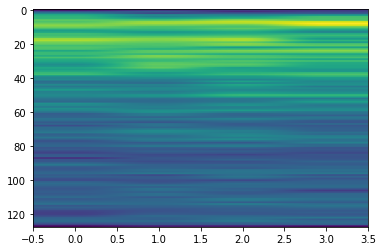

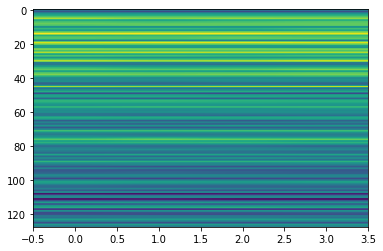

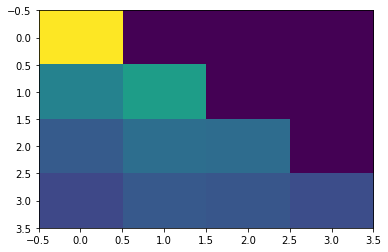

loss: 175.602371 - 
2021/05/11 20:40:03 Epoch  2 Train: loss: 172.049300 - 
2021/05/11 20:40:03 Epoch  2 Valid: 

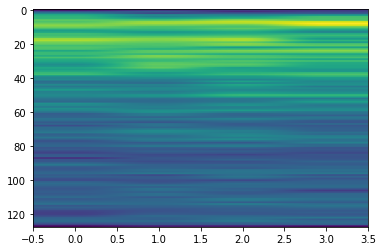

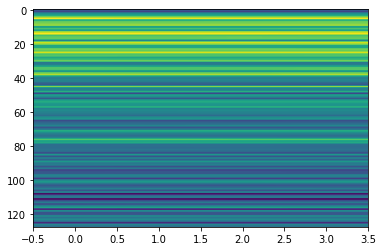

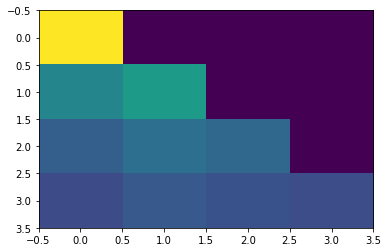

loss: 162.119885 - 
2021/05/11 20:40:09 Epoch  3 Train: loss: 155.269759 - 
2021/05/11 20:40:09 Epoch  3 Valid: 

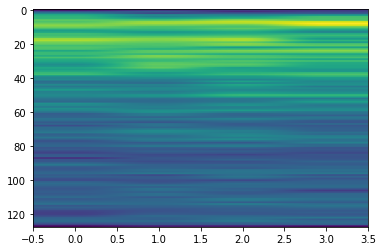

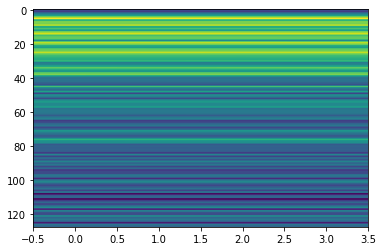

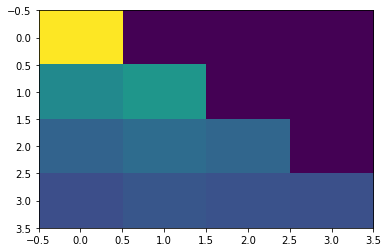

loss: 141.244777 - 
2021/05/11 20:40:15 Epoch  4 Train: loss: 130.202831 - 
2021/05/11 20:40:15 Epoch  4 Valid: 

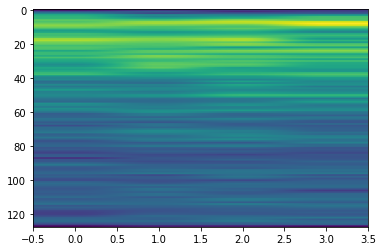

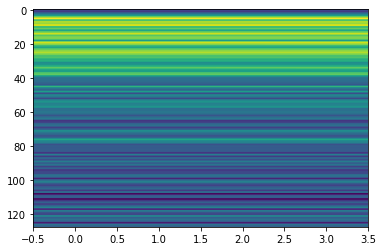

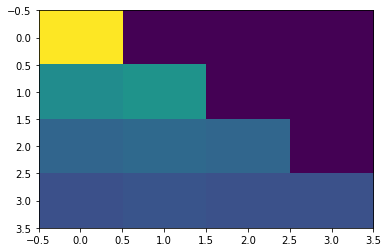

loss: 112.087345 - 
2021/05/11 20:40:21 Epoch  5 Train: loss: 99.071155 - 
2021/05/11 20:40:21 Epoch  5 Valid: 

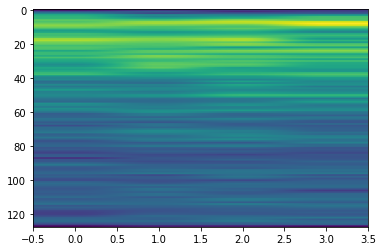

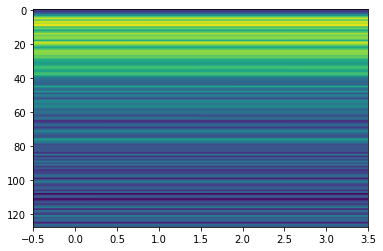

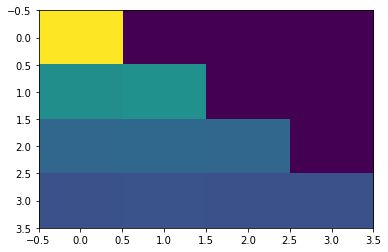

loss: 80.303041 - 
2021/05/11 20:40:27 Epoch  6 Train: loss: 69.528792 - 
2021/05/11 20:40:27 Epoch  6 Valid: 

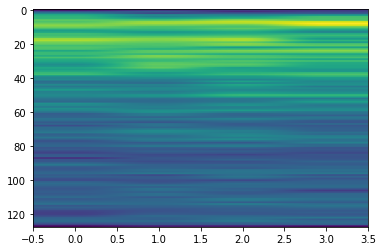

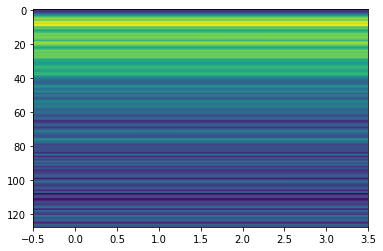

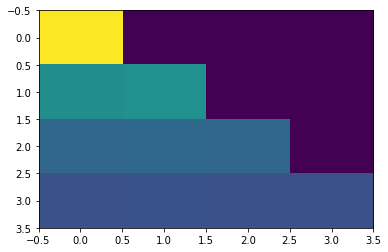

loss: 54.725814 - 
2021/05/11 20:40:33 Epoch  7 Train: loss: 48.914586 - 
2021/05/11 20:40:33 Epoch  7 Valid: 

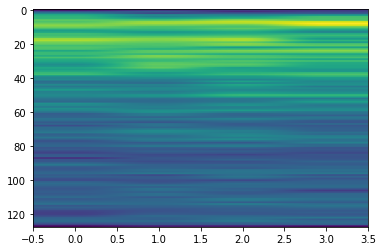

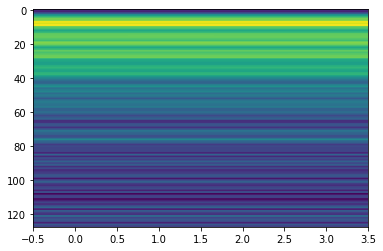

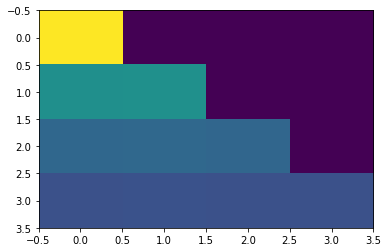

loss: 39.775857 - 
2021/05/11 20:40:39 Epoch  8 Train: loss: 38.110938 - 
2021/05/11 20:40:39 Epoch  8 Valid: 

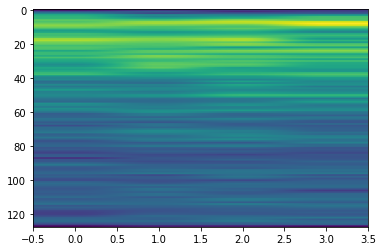

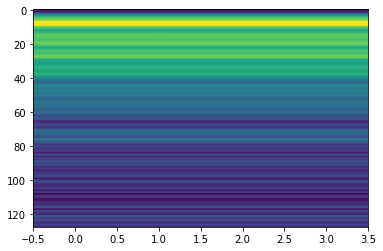

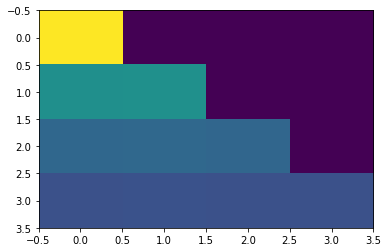

loss: 32.778117 - 
2021/05/11 20:40:45 Epoch  9 Train: loss: 33.144254 - 
2021/05/11 20:40:45 Epoch  9 Valid: 

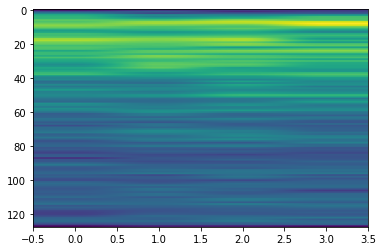

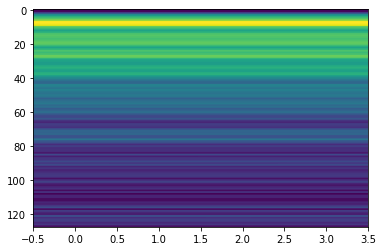

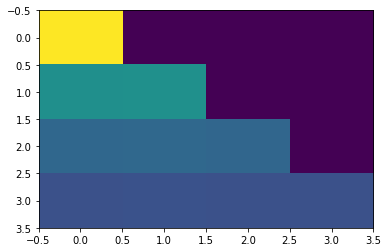

loss: 29.503510 - 
2021/05/11 20:40:52 Epoch 10 Train: loss: 30.737132 - 
2021/05/11 20:40:52 Epoch 10 Valid: 

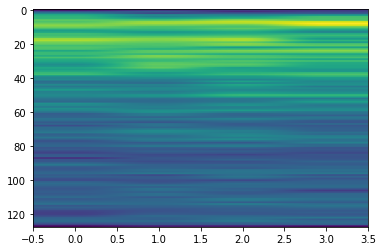

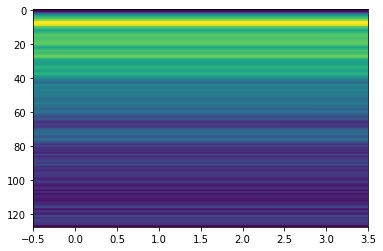

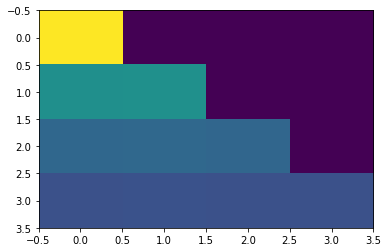

loss: 27.772949 - 
2021/05/11 20:40:58 Epoch 11 Train: loss: 28.363534 - 
2021/05/11 20:40:58 Epoch 11 Valid: 

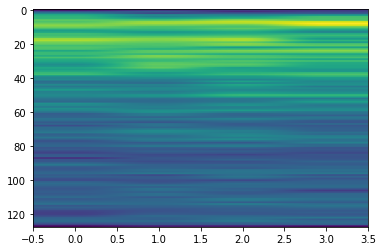

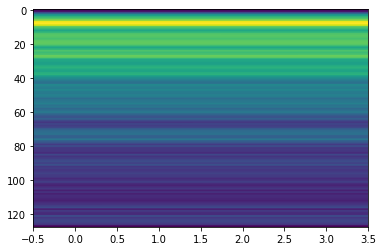

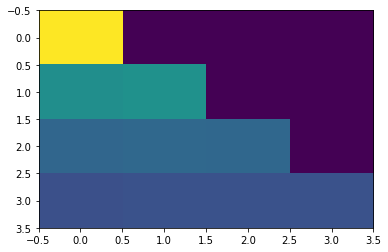

loss: 23.803747 - 
2021/05/11 20:41:04 Epoch 12 Train: loss: 25.348600 - 
2021/05/11 20:41:04 Epoch 12 Valid: 

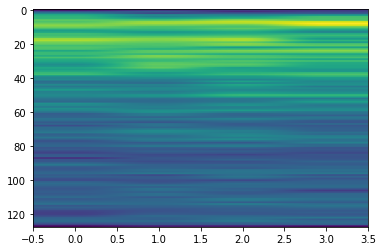

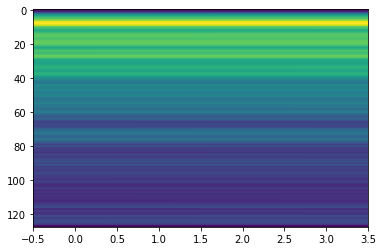

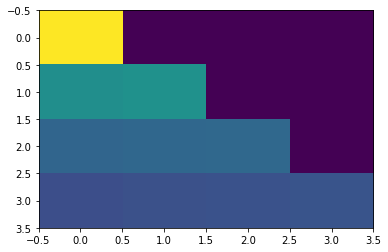

loss: 22.105779 - 
2021/05/11 20:41:11 Epoch 13 Train: loss: 24.086290 - 
2021/05/11 20:41:11 Epoch 13 Valid: 

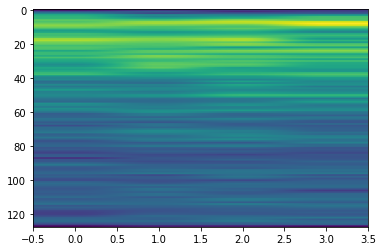

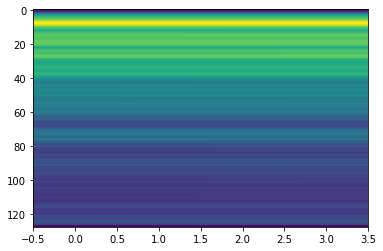

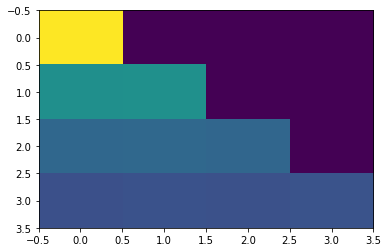

loss: 21.220685 - 
2021/05/11 20:41:17 Epoch 14 Train: loss: 23.356087 - 
2021/05/11 20:41:17 Epoch 14 Valid: 

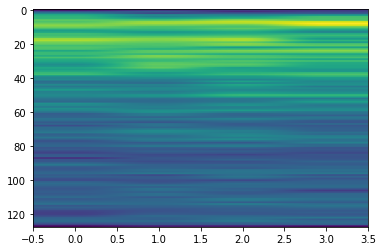

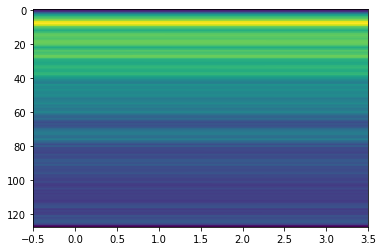

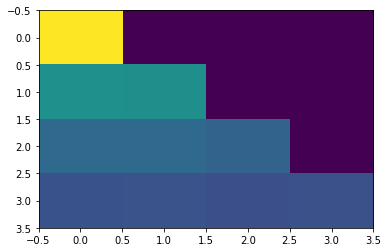

loss: 20.687515 - 
2021/05/11 20:41:23 Epoch 15 Train: loss: 22.852506 - 
2021/05/11 20:41:23 Epoch 15 Valid: 

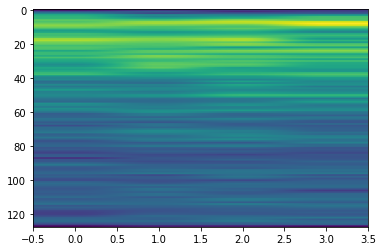

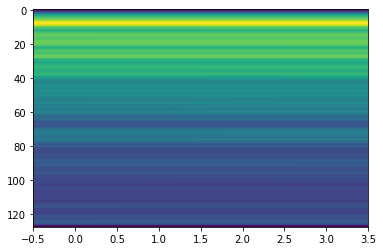

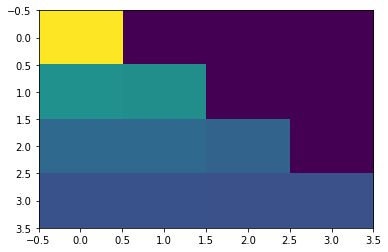

loss: 20.237185 - 
2021/05/11 20:41:29 Epoch 16 Train: 

KeyboardInterrupt: 

In [8]:
main(mode=True)